In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from scipy.integrate import odeint, solve_ivp

from dataset import Dataset
import NeuralNet 

%load_ext autoreload
%autoreload 2

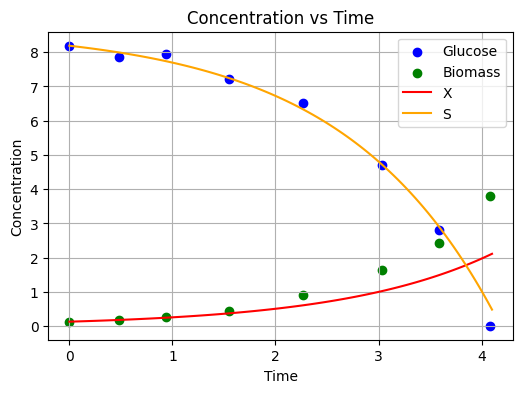

100%|██████████| 5000/5000 [00:17<00:00, 280.97it/s]

Train data shape: (4921, 19)


In [2]:
d = Dataset()
d.get_data(exp=1)

# Solve for 0.6794, 0.0002, 0.2572 kinetic parameter values
sol = d.solve_ode(mu_max=0.6794, Km=0.0002, Y_XS=0.2572)
d.plot_solution(sol)

# # Generate training data
train_df = d.training_dataset(N=5000)
print(f'Train data shape: {train_df.shape}')

In [3]:
X, y = NeuralNet.preprocess_data(train_df)
net = NeuralNet.NN()
# X_train, y_train, X_val, y_val = net.train_val_split(X, y)

losses_train = []
losses_val = []
for i in range(5000):
    loss_train = net.train(X, y)    
    losses_train.append(loss_train)
    # losses_val.append(loss_val)
    if i % 500 == 0:
        print(f'Epoch: {i}, Loss: {loss_train}')

Epoch: 0, Loss: 0.39205098152160645
Epoch: 500, Loss: 0.02670818567276001
Epoch: 1000, Loss: 0.022822629660367966
Epoch: 1500, Loss: 0.021443216130137444
Epoch: 2000, Loss: 0.02031002938747406
Epoch: 2500, Loss: 0.019751083105802536
Epoch: 3000, Loss: 0.018481234088540077
Epoch: 3500, Loss: 0.02126135677099228
Epoch: 4000, Loss: 0.018047695979475975
Epoch: 4500, Loss: 0.016403401270508766


In [4]:
# Evaluate on df experimental data
X_test, S_test = d.df['Biomass'].values, d.df['Glucose'].values

X_test, S_test = torch.tensor(X_test, dtype=torch.float32), torch.tensor(S_test, dtype=torch.float32)
test_df = torch.hstack((X_test, S_test)).view(1,-1)

# Predict
mu_max, Km, Y_XS = net.predict(test_df).detach().numpy().flatten()
print(f'Predicted mu_max: {mu_max}, Km: {Km}, Y_XS: {Y_XS}')

Predicted mu_max: 0.8472761511802673, Km: 0.09651742875576019, Y_XS: 0.43386778235435486


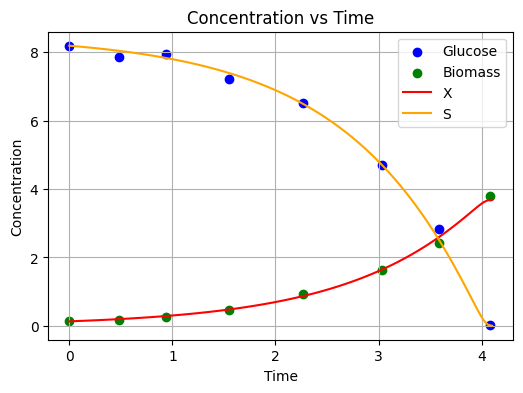

In [5]:
sol = d.solve_ode(mu_max=mu_max, Km=Km, Y_XS=Y_XS)
d.plot_solution(sol)

## PINN

In [6]:
from PINN import PINN, get_loss

%load_ext autoreload
%autoreload 2

pinn = PINN(1, 2)
optimizer = torch.optim.Adam(pinn.parameters(), lr=1e-4)
criterion = nn.MSELoss()

t_train = d.df['Time'].values
u_train = d.df[['Biomass', 'Glucose']].values

# Train data to tensor
ts_train = torch.tensor(t_train, requires_grad=True).float().view(-1,1)
us_train = torch.tensor(u_train, requires_grad=True).float()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
EPOCHS = 20000
LOSS = []
for epoch in range(EPOCHS):
    u_pred = pinn(ts_train)
    residual_pred = get_loss(pinn)
    loss = criterion(u_pred, us_train)
    loss += residual_pred
    LOSS.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 500 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}, ODE Loss: {torch.mean(residual_pred).item()}')

Epoch: 0, Loss: 20.916032791137695, ODE Loss: 0.0022074664011597633
Epoch: 500, Loss: 3.757800340652466, ODE Loss: 0.2901298403739929
Epoch: 1000, Loss: 1.0850472450256348, ODE Loss: 0.2790488004684448
Epoch: 1500, Loss: 0.7048625946044922, ODE Loss: 0.21151283383369446
Epoch: 2000, Loss: 0.4898276925086975, ODE Loss: 0.13514107465744019
Epoch: 2500, Loss: 0.34273451566696167, ODE Loss: 0.07998257130384445
Epoch: 3000, Loss: 0.24142572283744812, ODE Loss: 0.045790817588567734
Epoch: 3500, Loss: 0.17387895286083221, ODE Loss: 0.030072912573814392
Epoch: 4000, Loss: 0.12879040837287903, ODE Loss: 0.02344350889325142
Epoch: 4500, Loss: 0.09731214493513107, ODE Loss: 0.01967509649693966
Epoch: 5000, Loss: 0.07536376267671585, ODE Loss: 0.017014099285006523
Epoch: 5500, Loss: 0.06065536290407181, ODE Loss: 0.01488511823117733
Epoch: 6000, Loss: 0.05054079368710518, ODE Loss: 0.013087225146591663
Epoch: 6500, Loss: 0.04322749748826027, ODE Loss: 0.011683318763971329
Epoch: 7000, Loss: 0.0377

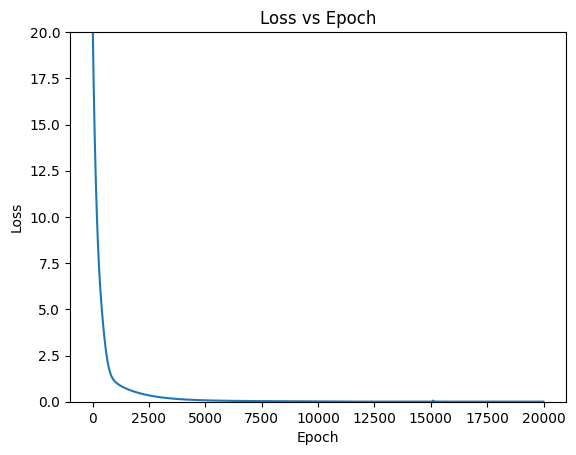

In [8]:
plt.plot(LOSS, label='Train')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, 20)
plt.title('Loss vs Epoch')
plt.show()

In [9]:
print(f'mu_max: {pinn.mu_max.item()}, Km: {pinn.Km.item()}, Y_XS: {pinn.Y_XS.item()}')

mu_max: 0.8003025650978088, Km: 0.00010694233060348779, Y_XS: 0.44406378269195557


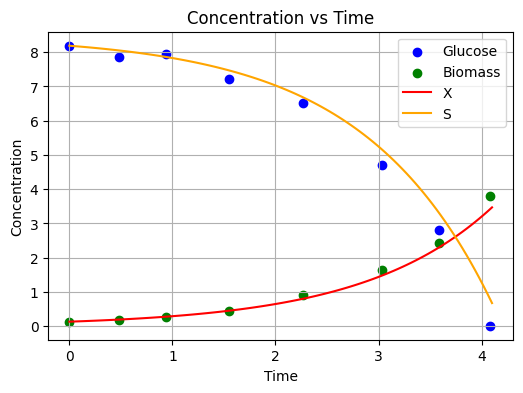

In [10]:
sol_pinn = d.solve_ode(mu_max=pinn.mu_max.item(), Km=pinn.Km.item(), Y_XS=pinn.Y_XS.item())
d.plot_solution(sol_pinn)